# Probabilistic Models
## Load Libraries

In [1]:
import pandas as pd
import pytimetk as tk
import lifetimes as lf
from lifetimes.plotting import plot_probability_alive_matrix

In [2]:
# Helper Function
from datetime import datetime

# differences in months.
def diff_month(d1, d2):
    if ((d1.year - d2.year) * 12 + d1.month - d2.month) == 0:
        return 1
    else:
        return (d1.year - d2.year) * 12 + d1.month - d2.month

In [3]:
# Helper Functions

# Converting Churn Rates:
###########################################################
# To convert annual churn to a monthly churn rate:
def churn_mthly_2_annual(mthly_churn_rate):
    return (1.0-((1.0-mthly_churn_rate)**(12)))

# To convert monthly churn to an annual churn rate:
def churn_annual_2_mthly(annual_churn_rate):
    return (1.0-((1.0-annual_churn_rate)**(1/12.0)))

# To convert churn rate to any period:
def churn_any_period_2_mthly(period_churn_rate, num_mths_in_period):
    return (1.0-((1.0-period_churn_rate)**(1/num_mths_in_period)))


# Customer Lifetime Value
###########################################################
# Customer Lifetime Months 
def cust_lifetime_in_mths(MonthlyChurnRate):
    return (1 / MonthlyChurnRate)

# Customer Lifetime Years
def cust_lifetime_in_years(MonthlyChurnRate):
    return (cust_lifetime_in_mths(MonthlyChurnRate) / 12.0)

# Monthly Churn Rate % from customer lifetime in months.
def mthly_churn_rate_from_mthly_lifetime(CustomerLifetimeMonths):
    return (1 / CustomerLifetimeMonths)

# Monthly Churn Rate % from customer lifetime in years.
def mthly_churn_rate_from_yearly_lifetime(CustomerLifetimeYears):
    return (1 / (CustomerLifetimeYears * 12))
    
# Decay
###########################################################
# Want to know how many customers will remain after 6, 12, 24 months?
# Here is how to calculate how many customers in a cohort will be left at Month X, 
# using exponential decay.

def custs_remaining(MonthlyChurnRate, StartingCohortCount, NumberOfMonthsInTheFuture):
    return (StartingCohortCount * ((1 - MonthlyChurnRate) ^ NumberOfMonthsInTheFuture))


# Calculate Churn
###########################################################
# Annual Churn Rate
def annual_churn_rate(CohortYearStartCount, CohortYearEndCount):
    return ((CohortYearStartCount - CohortYearEndCount) / CohortYearStartCount)

# Monthly Churn Rate
def mthly_churn_rate(CohortMonthStartCount, CohortMonthEndCount):
    return ((CohortMonthStartCount - CohortMonthEndCount) / CohortMonthStartCount)

# Any Period Churn Rate
def any_period_churn_rate(CohortPeriodStartCount, CohortPeriodEndCount):
    return ((CohortPeriodStartCount - CohortPeriodEndCount) / CohortPeriodStartCount)


In [4]:
# constants 
profit_margin = 0.15 #15% Profit on Products


## Import Data

In [5]:
# Accomodate raw path to variables
raw_customer, raw_orders = "./input/customers.csv", "./input/orders.csv"
raw_products, raw_sales = "./input/products.csv", "./input/sales.csv"

# Read-in data
customer, order = pd.read_csv(raw_customer), pd.read_csv(raw_orders)
product, sales_data = pd.read_csv(raw_products), pd.read_csv(raw_sales)

In [6]:
print(order['order_date'].min())
print(order['order_date'].max())

2021-1-1
2021-9-9


In [7]:
order.head(3)

,order_id,customer_id,payment,order_date,delivery_date
0,1,64,30811,2021-8-30,2021-09-24
1,2,473,50490,2021-2-3,2021-02-13
2,3,774,46763,2021-10-8,2021-11-03


In [8]:
df = order.copy()
df['order_date'] = pd.to_datetime(df['order_date'])

In [9]:
# Select a cohort
df1 = df[(df['order_date']>=datetime(2021, 4, 1))&
         (df['order_date']<datetime(2021, 5, 1))]
df1.head(3)

,order_id,customer_id,payment,order_date,delivery_date
6,7,626,37666,2021-04-05,2021-04-11
7,8,58,28484,2021-04-12,2021-05-01
20,21,124,11261,2021-04-04,2021-04-17


## EDA

In [10]:
(df[['order_date','payment']].summarize_by_time(
    date_column = 'order_date',
    value_column = 'payment',
    agg_func = 'sum',
    freq = 'M'
)
 .plot_timeseries('order_date','payment'))

In [11]:
(df[['order_date','payment']].summarize_by_time(
    date_column = 'order_date',
    value_column = 'payment',
    agg_func = 'sum',
    freq = 'D'
)
 .plot_timeseries('order_date','payment'))

In [12]:
(df1[['order_date','payment']].summarize_by_time(
    date_column = 'order_date',
    value_column = 'payment',
    agg_func = 'sum',
    freq = 'D'
)
 .plot_timeseries('order_date','payment'))

# Aggregation Models
Aggregation models are used to calculate the average custoemr lifetime value for a group of customer or a cohort.

In [36]:
df.sort_values('payment')

,order_id,customer_id,payment,order_date,delivery_date
442,443,966,10043,2021-03-09,2021-03-27
288,289,977,10046,2021-01-26,2021-02-16
490,491,783,10074,2021-02-24,2021-03-18
485,486,643,10132,2021-04-27,2021-05-08
625,626,348,10193,2021-09-30,2021-10-17
...,...,...,...,...,...
446,447,100,59708,2021-01-10,2021-01-23
682,683,276,59748,2021-01-01,2021-01-05
237,238,328,59828,2021-03-17,2021-03-27
315,316,179,59876,2021-09-12,2021-09-20


In [13]:
df.columns

Index(['order_id', 'customer_id', 'payment', 'order_date', 'delivery_date'], dtype='object')

In [25]:
summary_3_df = (lf
                .utils
                .summary_data_from_transaction_data(
                    df,
                    customer_id_col = 'customer_id',
                    datetime_col = 'order_date',
                    monetary_value_col = 'payment'
                    )
                )

# Remove Empty orders
summary_3_df = summary_3_df[summary_3_df['monetary_value'] > 0]
# Remove 0 Frequency
summary_3_df = summary_3_df[summary_3_df['frequency'] > 0]

summary_3_df

,frequency,recency,T,monetary_value
customer_id,,,,
1,2.0,45.0,248.0,17398.0
15,1.0,132.0,193.0,50335.0
18,1.0,35.0,275.0,33908.0
20,1.0,224.0,228.0,37821.0
21,2.0,132.0,290.0,26771.0
...,...,...,...,...
986,1.0,246.0,275.0,32747.0
987,1.0,30.0,252.0,48827.0
989,1.0,130.0,285.0,51250.0


# BG/NBD Model
This predicts the number of repeat purchases a customer will make.

In [26]:
# Note: If this dosn't converge increase the peanlizer coef.

bgf = lf.BetaGeoFitter(penalizer_coef=0.15)

bgf.fit(summary_3_df['frequency'], summary_3_df['recency'], summary_3_df['T'])

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.930120,0.066202,0.800363,1.059876
alpha,76.537601,9.214716,58.476758,94.598445
a,0.208022,0.058314,0.093727,0.322317
b,0.252246,0.063029,0.128709,0.375783


In [27]:
# Conditional Probability Alive
summary_3_df['probability_alive'] = (bgf
                                     .conditional_probability_alive(
                                         summary_3_df['frequency'], 
                                         summary_3_df['recency'], 
                                         summary_3_df['T']))

summary_3_df

,frequency,recency,T,monetary_value,probability_alive
customer_id,,,,,
1,2.0,45.0,248.0,17398.0,0.252968
15,1.0,132.0,193.0,50335.0,0.424950
18,1.0,35.0,275.0,33908.0,0.116816
20,1.0,224.0,228.0,37821.0,0.541713
21,2.0,132.0,290.0,26771.0,0.535569
...,...,...,...,...,...
986,1.0,246.0,275.0,32747.0,0.506646
987,1.0,30.0,252.0,48827.0,0.121228
989,1.0,130.0,285.0,51250.0,0.291547


<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

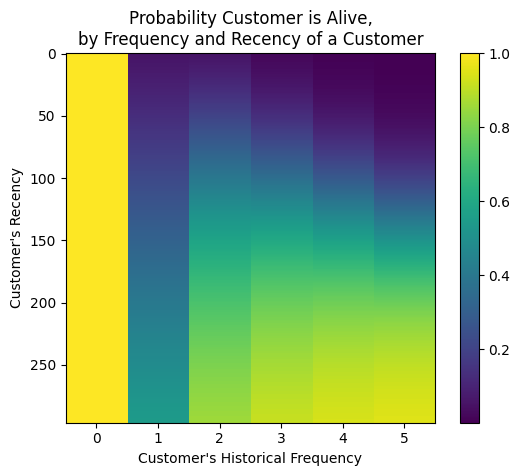

In [28]:
plot_probability_alive_matrix(bgf, cmap='viridis')

# Gamma-Gamma Model
This model is used to predict the average transaction value for each customer.


In [30]:
ggf = lf.GammaGammaFitter(penalizer_coef=0.1)

ggf.fit(summary_3_df['frequency'], summary_3_df['monetary_value'])

ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,0.834296,0.091962,0.654049,1.014542
q,0.091096,0.005906,0.079521,0.102672
v,0.674817,0.099916,0.478982,0.870652


In [32]:
summary_3_df['predicted_avg_sales'] = (ggf
                                     .conditional_expected_average_profit(
                                         summary_3_df['frequency'], 
                                         summary_3_df['monetary_value']
                                     ))

summary_3_df

,frequency,recency,T,monetary_value,probability_alive,predicted_avg_sales
customer_id,,,,,,
1,2.0,45.0,248.0,17398.0,0.252968,38214.027857
15,1.0,132.0,193.0,50335.0,0.424950,-562870.987241
18,1.0,35.0,275.0,33908.0,0.116816,-379178.571453
20,1.0,224.0,228.0,37821.0,0.541713,-422935.095650
21,2.0,132.0,290.0,26771.0,0.535569,58801.057221
...,...,...,...,...,...,...
986,1.0,246.0,275.0,32747.0,0.506646,-366195.866472
987,1.0,30.0,252.0,48827.0,0.121228,-546008.007817
989,1.0,130.0,285.0,51250.0,0.291547,-573102.834837


In [37]:
# Predict the customers CLV for next 90 Days

summary_3_df['predicted_clv_3mths'] = (ggf
                                       .customer_lifetime_value(
                                           bgf,
                                           summary_3_df['frequency'], 
                                           summary_3_df['recency'],
                                           summary_3_df['T'],
                                           summary_3_df['monetary_value'],
                                           time=3, # Time Horizon in Months
                                           freq='D', # Daily if Data set is Daily
                                           discount_rate=0.01 # 1% Discount Rate
                                       )
)

# Adjust for Profit Margin
summary_3_df['predicted_clv_3mths'] = summary_3_df['predicted_clv_3mths']*profit_margin

summary_3_df

,frequency,recency,T,monetary_value,probability_alive,predicted_avg_sales,predicted_clv_3mths
customer_id,,,,,,,
1,2.0,45.0,248.0,17398.0,0.252968,38214.027857,1109.110100
15,1.0,132.0,193.0,50335.0,0.424950,-562870.987241,-21363.559770
18,1.0,35.0,275.0,33908.0,0.116816,-379178.571453,-3070.856402
20,1.0,224.0,228.0,37821.0,0.541713,-422935.095650,-18219.473926
21,2.0,132.0,290.0,26771.0,0.535569,58801.057221,3212.591817
...,...,...,...,...,...,...,...
986,1.0,246.0,275.0,32747.0,0.506646,-366195.866472,-12862.619832
987,1.0,30.0,252.0,48827.0,0.121228,-546008.007817,-4896.016820
989,1.0,130.0,285.0,51250.0,0.291547,-573102.834837,-11276.495488


In [38]:
# Predict the customers CLV for next 180 Days

summary_3_df['predicted_clv_6mths'] = (ggf
                                       .customer_lifetime_value(
                                           bgf,
                                           summary_3_df['frequency'], 
                                           summary_3_df['recency'],
                                           summary_3_df['T'],
                                           summary_3_df['monetary_value'],
                                           time=6, # Time Horizon in Months
                                           freq='D', # Daily if Data set is Daily
                                           discount_rate=0.01 # 1% Discount Rate
                                       )
)

# Adjust for Profit Margin
summary_3_df['predicted_clv_6mths'] = summary_3_df['predicted_clv_6mths']*profit_margin

summary_3_df

,frequency,recency,T,monetary_value,probability_alive,predicted_avg_sales,predicted_clv_3mths,predicted_clv_6mths
customer_id,,,,,,,,
1,2.0,45.0,248.0,17398.0,0.252968,38214.027857,1109.110100,2115.729194
15,1.0,132.0,193.0,50335.0,0.424950,-562870.987241,-21363.559770,-40253.966332
18,1.0,35.0,275.0,33908.0,0.116816,-379178.571453,-3070.856402,-5829.493627
20,1.0,224.0,228.0,37821.0,0.541713,-422935.095650,-18219.473926,-34450.735287
21,2.0,132.0,290.0,26771.0,0.535569,58801.057221,3212.591817,6145.338856
...,...,...,...,...,...,...,...,...
986,1.0,246.0,275.0,32747.0,0.506646,-366195.866472,-12862.619832,-24417.475303
987,1.0,30.0,252.0,48827.0,0.121228,-546008.007817,-4896.016820,-9277.285725
989,1.0,130.0,285.0,51250.0,0.291547,-573102.834837,-11276.495488,-21422.378426
